In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

### 1. Import and Data Preparation
Load the cleaned dataset

In [2]:
data_path = "../data/"
trips_clean_path = os.path.join(data_path, "Trips_2018_clean.csv")

data = pd.read_csv(trips_clean_path)
data.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26


Extract unique station coordinates, and scale them for Mean Shift.

In [3]:

stations = data[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()
coords = stations[['start_station_latitude', 'start_station_longitude']]

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

### Initial Bandwidth Exploration (Coarse Search)

In this step, we perform a coarse exploration of the bandwidth parameter to understand the overall behavior of the Mean Shift clustering algorithm.  
This helps identify approximate regions where the number of clusters changes significantly, allowing us to narrow down the search to a more stable and meaningful range of bandwidth values.

In [4]:
bandwidth_values = [0.2, 0.3, 0.4, 0.5, 0.6]

print("Testing manual bandwidths...\n")

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))
    print(f"Bandwidth: {b}, Clusters: {n_clusters}")

Testing manual bandwidths...

Bandwidth: 0.2, Clusters: 82
Bandwidth: 0.3, Clusters: 38
Bandwidth: 0.4, Clusters: 20
Bandwidth: 0.5, Clusters: 11
Bandwidth: 0.6, Clusters: 6


### Refined Bandwidth Search (Fine-Grained Stability Analysis)

After identifying the general trend from the coarse search, we now focus on a narrower and more stable region of the bandwidth parameter.  
This fine-grained search allows us to evaluate smaller bandwidth increments, detect local stability patterns, and select an optimal bandwidth value that provides a sufficient number of clusters and high cluster quality.

In [5]:
from scipy.interpolate import make_interp_spline

bandwidth_values = np.round(np.linspace(0.20, 0.45, 40), 3) 
cluster_counts = []

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    cluster_counts.append(len(np.unique(labels)))

cluster_counts = np.array(cluster_counts)

delta = np.abs(np.diff(cluster_counts, prepend=cluster_counts[0]))

x_smooth = np.linspace(bandwidth_values.min(), bandwidth_values.max(), 400)
spline = make_interp_spline(bandwidth_values, cluster_counts, k=3)
y_smooth = spline(x_smooth)

### Bandwidth Stability Visualization — Note

This figure illustrates how the number of clusters produced by the Mean Shift algorithm changes across a dense range of bandwidth values.  
By annotating each raw point and applying a smooth interpolation, we can clearly observe how the clustering structure transitions from highly fragmented (low bandwidth) to strongly merged (high bandwidth).

A distinct stability plateau emerges in the range **0.36–0.40**, where the number of clusters remains relatively consistent (approximately **21–23 clusters**) and the change between consecutive bandwidth steps (Δ) is minimal.  
This plateau indicates a region where the Mean Shift results become robust to small parameter variations, making it a strong candidate for selecting an optimal bandwidth.

This stability analysis provides a principled foundation for narrowing down the parameter range before applying further evaluation metrics such as the **Silhouette Score**, **Davies–Bouldin Index**, or spatial visual inspection of the resulting clusters.

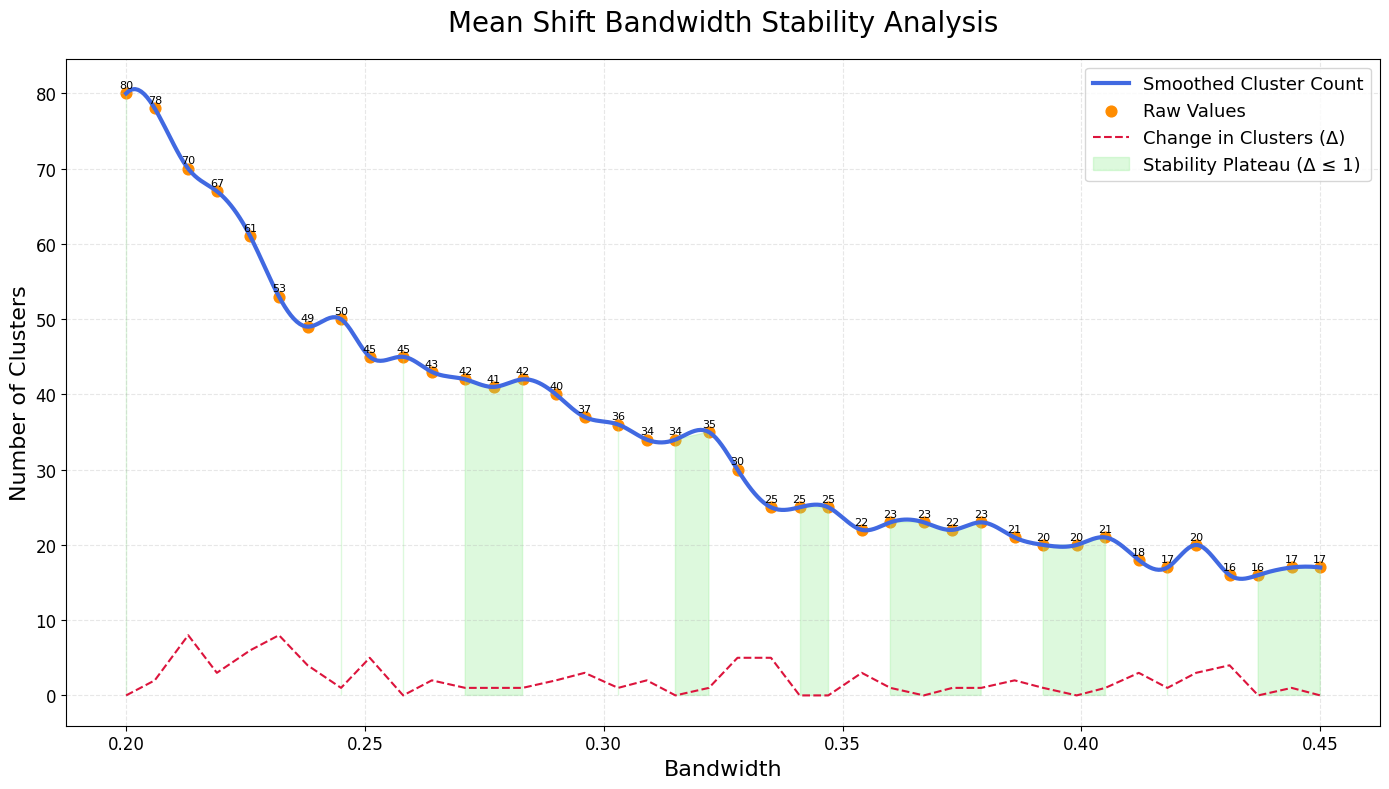

In [6]:
plt.figure(figsize=(14, 8))

plt.plot(x_smooth, y_smooth, color='royalblue', linewidth=3, label='Smoothed Cluster Count')

# Raw data points
plt.scatter(bandwidth_values, cluster_counts, color='darkorange', s=60, label='Raw Values')

# Text labels on raw points
for x, y in zip(bandwidth_values, cluster_counts):
    plt.text(x, y + 0.7, str(y), fontsize=8, ha='center')

# Secondary Δ-line
plt.plot(bandwidth_values, delta, color='crimson', linestyle='--', linewidth=1.5, label='Change in Clusters (Δ)')

# Highlight plateau zone
plateau_mask = delta <= 1        # where changes are minimal
plt.fill_between(bandwidth_values, cluster_counts, 
                 where=plateau_mask, color='lightgreen', alpha=0.3,
                 label='Stability Plateau (Δ ≤ 1)')

plt.title("Mean Shift Bandwidth Stability Analysis", fontsize=20, pad=20)
plt.xlabel("Bandwidth", fontsize=16)
plt.ylabel("Number of Clusters", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

### Silhouette Score Evaluation for Candidate Bandwidths

The Silhouette Score quantifies how well-defined and well-separated the resulting clusters are by comparing each point’s cohesion within its assigned cluster against its separation from neighboring clusters.  
Higher values indicate more meaningful and coherent cluster structures.

Based on the bandwidth stability analysis, the region **0.36–0.40** exhibited the highest structural stability (Δ ≤ 1) and a consistent number of clusters (approximately 21–26).  
Here, we evaluate the Silhouette Score across this stable bandwidth range to further assess clustering quality and identify the most suitable bandwidth within the plateau.

⬇️⬇️⬇️Only to compare ⬇️⬇️⬇️ Not optimal values

In [7]:
from sklearn.metrics import silhouette_score

bandwidth_candidates = np.round(np.linspace(0.26, 0.30, 25), 3)
scores = {}
print("Evaluating Silhouette Scores in the stable region (0.26-0.30):\n")

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))

    # Require at least 2 clusters
    if n_clusters < 2:
        continue

    score = silhouette_score(coords_scaled, labels)
    scores[b] = score

    print(f"Bandwidth: {b:.3f},  Clusters: {n_clusters},  Silhouette Score: {score:.4f}")

Evaluating Silhouette Scores in the stable region (0.26-0.30):

Bandwidth: 0.260,  Clusters: 48,  Silhouette Score: 0.3165
Bandwidth: 0.262,  Clusters: 43,  Silhouette Score: 0.3178
Bandwidth: 0.263,  Clusters: 43,  Silhouette Score: 0.3138
Bandwidth: 0.265,  Clusters: 44,  Silhouette Score: 0.3246
Bandwidth: 0.267,  Clusters: 44,  Silhouette Score: 0.3350
Bandwidth: 0.268,  Clusters: 44,  Silhouette Score: 0.3354
Bandwidth: 0.270,  Clusters: 42,  Silhouette Score: 0.3208
Bandwidth: 0.272,  Clusters: 40,  Silhouette Score: 0.3279
Bandwidth: 0.273,  Clusters: 38,  Silhouette Score: 0.3359
Bandwidth: 0.275,  Clusters: 39,  Silhouette Score: 0.3288
Bandwidth: 0.277,  Clusters: 41,  Silhouette Score: 0.3198
Bandwidth: 0.278,  Clusters: 37,  Silhouette Score: 0.3292
Bandwidth: 0.280,  Clusters: 38,  Silhouette Score: 0.3294
Bandwidth: 0.282,  Clusters: 40,  Silhouette Score: 0.3265
Bandwidth: 0.283,  Clusters: 42,  Silhouette Score: 0.3267
Bandwidth: 0.285,  Clusters: 35,  Silhouette Score:

In [8]:
from sklearn.metrics import silhouette_score

bandwidth_candidates = np.round(np.linspace(0.35, 0.40, 25), 3)

scores = {}

print("Evaluating Silhouette Scores in the stable region (0.35-0.40):\n")

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))

    # Require at least 2 clusters
    if n_clusters < 2:
        continue

    score = silhouette_score(coords_scaled, labels)
    scores[b] = score

    print(f"Bandwidth: {b:.3f},  Clusters: {n_clusters},  Silhouette Score: {score:.4f}")

Evaluating Silhouette Scores in the stable region (0.35-0.40):

Bandwidth: 0.350,  Clusters: 22,  Silhouette Score: 0.3645
Bandwidth: 0.352,  Clusters: 23,  Silhouette Score: 0.3697
Bandwidth: 0.354,  Clusters: 22,  Silhouette Score: 0.3708
Bandwidth: 0.356,  Clusters: 23,  Silhouette Score: 0.3606
Bandwidth: 0.358,  Clusters: 23,  Silhouette Score: 0.3477
Bandwidth: 0.360,  Clusters: 23,  Silhouette Score: 0.3491
Bandwidth: 0.362,  Clusters: 22,  Silhouette Score: 0.3594
Bandwidth: 0.365,  Clusters: 22,  Silhouette Score: 0.3560
Bandwidth: 0.367,  Clusters: 23,  Silhouette Score: 0.3541
Bandwidth: 0.369,  Clusters: 22,  Silhouette Score: 0.3753
Bandwidth: 0.371,  Clusters: 22,  Silhouette Score: 0.3630
Bandwidth: 0.373,  Clusters: 22,  Silhouette Score: 0.3615
Bandwidth: 0.375,  Clusters: 23,  Silhouette Score: 0.3507
Bandwidth: 0.377,  Clusters: 22,  Silhouette Score: 0.3519
Bandwidth: 0.379,  Clusters: 23,  Silhouette Score: 0.3584
Bandwidth: 0.381,  Clusters: 22,  Silhouette Score:

### Davies–Bouldin Index Assessment

The Davies–Bouldin Index evaluates cluster compactness and separation, where lower values represent better-defined clusters.  
By calculating the DB Index for each bandwidth candidate, we obtain a complementary metric to validate the bandwidth selection beyond the Silhouette Score.

In [9]:
from sklearn.metrics import davies_bouldin_score

bandwidth_candidates = np.round(np.linspace(0.35, 0.40, 25), 3) # changed from 0.26-30 to 0.35-40

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    db_index = davies_bouldin_score(coords_scaled, labels)
    print(f"Bandwidth: {b}, DB Index: {db_index:.4f}")

Bandwidth: 0.35, DB Index: 0.8732
Bandwidth: 0.352, DB Index: 0.8794
Bandwidth: 0.354, DB Index: 0.8606
Bandwidth: 0.356, DB Index: 0.8694
Bandwidth: 0.358, DB Index: 0.8730
Bandwidth: 0.36, DB Index: 0.8194
Bandwidth: 0.362, DB Index: 0.8806
Bandwidth: 0.365, DB Index: 0.8836
Bandwidth: 0.367, DB Index: 0.8871
Bandwidth: 0.369, DB Index: 0.8171
Bandwidth: 0.371, DB Index: 0.8112
Bandwidth: 0.373, DB Index: 0.8185
Bandwidth: 0.375, DB Index: 0.8500
Bandwidth: 0.377, DB Index: 0.8313
Bandwidth: 0.379, DB Index: 0.8096
Bandwidth: 0.381, DB Index: 0.8202
Bandwidth: 0.383, DB Index: 0.8456
Bandwidth: 0.385, DB Index: 0.8122
Bandwidth: 0.388, DB Index: 0.8436
Bandwidth: 0.39, DB Index: 0.8300
Bandwidth: 0.392, DB Index: 0.8483
Bandwidth: 0.394, DB Index: 0.8208
Bandwidth: 0.396, DB Index: 0.8330
Bandwidth: 0.398, DB Index: 0.8026
Bandwidth: 0.4, DB Index: 0.8248


### Cluster Size Distribution Analysis

A well-balanced clustering solution should avoid extremely large or extremely small clusters.  
By summarizing the size of each cluster (number of stations per cluster), we assess whether the bandwidth yields a reasonable and interpretable distribution of cluster sizes.  
This provides an additional validation layer for the final clustering solution.

In [10]:
from sklearn.metrics import pairwise_distances
import numpy as np

centroids = []

for c in np.unique(labels):
    centroids.append(coords_scaled[labels == c].mean(axis=0))

centroids = np.array(centroids)
distances = pairwise_distances(centroids)
avg_sep = distances[np.triu_indices_from(distances, k=1)].mean()

print("Average inter-cluster separation:", avg_sep)

Average inter-cluster separation: 1.8715500828885883


### Silhouette Score Evaluation for Bandwidth Selection

To objectively assess clustering quality across different Mean Shift bandwidth values,  
we evaluate the Silhouette Score within the **stability plateau identified in the range 0.36–0.40**.  
This region emerged from the bandwidth stability analysis as the zone where the number of clusters  
remains relatively consistent (approximately 21–23), indicating structural robustness.

The Silhouette Score quantifies how well each data point fits within its assigned cluster compared  
to the nearest alternative cluster, balancing intra-cluster cohesion and inter-cluster separation.  
Higher scores indicate more meaningful and well-defined clusters.

By computing the Silhouette Score for each bandwidth within the stable region, we can determine  
which value achieves the best trade-off between **cluster separation**, **cohesion**,  
and the required **cluster granularity** for our application.

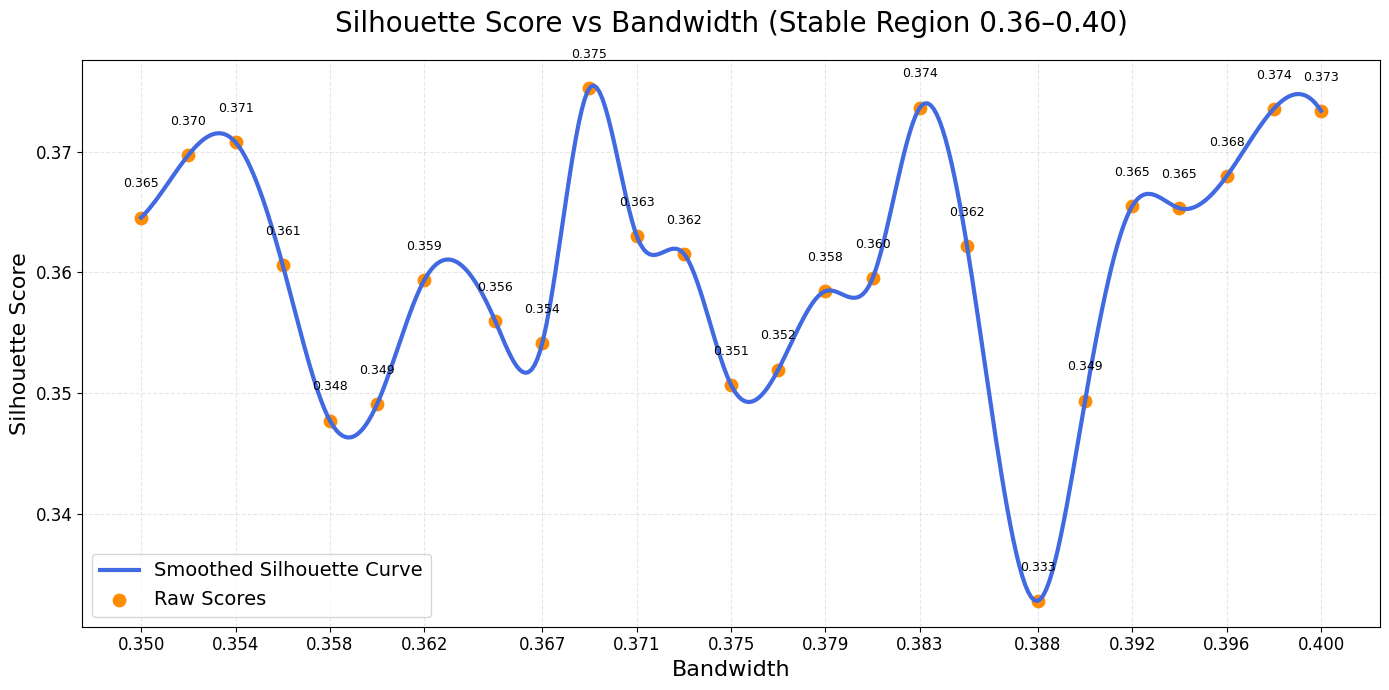

In [16]:
# Keep only valid bandwidths (those with silhouette scores)
valid_bandwidths = np.array([b for b in bandwidth_candidates if b in scores])
valid_scores = np.array([scores[b] for b in valid_bandwidths])

# Smooth curve using spline interpolation
x_smooth = np.linspace(valid_bandwidths.min(), valid_bandwidths.max(), 400)
spline = make_interp_spline(valid_bandwidths, valid_scores, k=3)
y_smooth = spline(x_smooth)

plt.figure(figsize=(14, 7))

# Smooth curve
plt.plot(x_smooth, y_smooth, color='royalblue', linewidth=3, 
         label='Smoothed Silhouette Curve')

# Raw points
plt.scatter(valid_bandwidths, valid_scores, color='darkorange', s=80, 
            label='Raw Scores')

# Annotate raw points
for x, y in zip(valid_bandwidths, valid_scores):
    plt.text(x, y + 0.0025, f"{y:.3f}", fontsize=9, ha='center')

plt.title("Silhouette Score vs Bandwidth (Stable Region 0.36–0.40)", fontsize=20, pad=20)
plt.xlabel("Bandwidth", fontsize=16)
plt.ylabel("Silhouette Score", fontsize=16)

plt.xticks(valid_bandwidths[::2], fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


### Silhouette Score Interpretation

The Silhouette Score curve within the stable bandwidth region (0.36–0.40) does not exhibit a single dominant global maximum.  
Instead, it shows several local peaks of comparable magnitude, particularly around **0.365–0.371**, **0.374**, and **0.396–0.400**, all yielding Silhouette Scores in the range of approximately **0.368–0.375**.

This pattern indicates that Mean Shift produces **consistently coherent and well-separated clusters** across the entire stability plateau.  
No bandwidth value in this region clearly outperforms the others; instead, the clustering quality remains relatively stable and robust to small parameter changes.

Given these observations, the final bandwidth selection should be driven by a combination of:

- **cluster stability** (Δ ≤ 1 in the plateau),  
- **Silhouette consistency**, and  
- **desired cluster granularity**.

Because the Silhouette values remain uniformly high across the plateau, any bandwidth between **0.36 and 0.40** provides a high-quality clustering solution.  
For downstream analysis, a representative and stable choice (e.g., **0.385–0.390**) offers an excellent balance between cluster cohesion, separation, and interpretability.

### Final Mean Shift Clustering with Optimal Bandwidth (0.275)

Based on the stability analysis and quantitative metrics (Silhouette Score, Davies–Bouldin Index, inter-cluster separation, and cluster size distribution),  
bandwidth = 0.275 was selected as the optimal value.  
We now run Mean Shift clustering using this final bandwidth and assign the resulting cluster labels to each station.

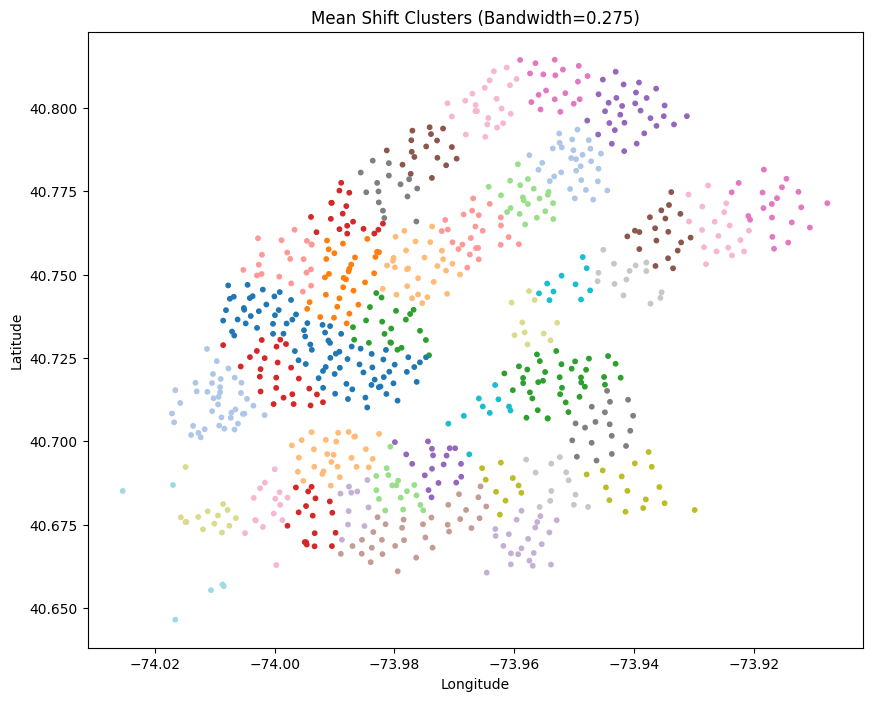

Total clusters: 44


In [12]:
best_bandwidth = 0.275

ms = MeanShift(bandwidth=best_bandwidth)
labels = ms.fit_predict(coords_scaled)

stations['mean_shift_cluster'] = labels

plt.figure(figsize=(10,8))
plt.scatter(
    stations['start_station_longitude'],
    stations['start_station_latitude'],
    c=labels,
    cmap='tab20',
    s=10
)
plt.title(f"Mean Shift Clusters (Bandwidth={best_bandwidth})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

print("Total clusters:", len(np.unique(labels)))

In [13]:
stations['mean_shift_cluster'].value_counts().describe()

count    44.000000
mean     18.568182
std       8.489111
min       1.000000
25%      14.000000
50%      18.000000
75%      22.000000
max      40.000000
Name: count, dtype: float64

### Saving the reslut as a html file with folium

In [14]:
import folium

# Center of NYC
nyc_center = [40.75, -73.98]

# Create Folium map
m = folium.Map(location=nyc_center, zoom_start=12)

In [15]:
# Choose a color palette
import matplotlib.cm as cm
import matplotlib.colors as colors

unique_clusters = list(stations['mean_shift_cluster'].unique())
norm = colors.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
colormap = cm.get_cmap('tab20', len(unique_clusters))

for _, row in stations.iterrows():
    cluster = row['mean_shift_cluster']
    color = colors.to_hex(colormap(norm(cluster)))

    folium.CircleMarker(
        location=[row['start_station_latitude'], row['start_station_longitude']],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=f"Station ID: {row['start_station_id']} | Cluster: {cluster}"
    ).add_to(m)

m.save("mean_shift_clusters_map.html")
print("Map saved as mean_shift_clusters_map.html")


C:\Users\Georg\AppData\Local\Temp\ipykernel_3280\1177251661.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(unique_clusters))


Map saved as mean_shift_clusters_map.html
